<a href="https://colab.research.google.com/github/kad99kev/Image-Inpainting/blob/main/PartialConvolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing Dependencies

In [1]:
!pip install wandb

# Importing Libraries

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import wandb
import cv2
from tqdm.notebook import tqdm

# Initialize Constants

In [4]:
image_dims = (32, 32)
batch_size = 32
n_channels = 3
epochs = 20

In [5]:
config = {
    'epochs': 20,
    'image_dims': image_dims,
    'n_channels': n_channels,
    'batch_size': batch_size
}
wandb.init(entity='kad99kev', project='inpainting', name='partial_convolution', config=config)

wandb: Currently logged in as: kad99kev (use `wandb login --relogin` to force relogin)


In [6]:
def show_grid(img):
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

# Prepare Dataset

In [7]:
class Cifar(torchvision.datasets.CIFAR10):
    def __init__(self, path, image_dims=(32, 32), n_channels=3, train=True):
        super().__init__(path, train, download=True)
        self.n_classes = 10
        self.image_dims = image_dims
        self.n_channels = n_channels
        self.resize = transforms.Resize(image_dims)
        self.to_tensor = transforms.ToTensor()

    def __getitem__(self, index):
        image, label = super().__getitem__(index)

        y_output = self.resize(image)
        X_input, X_mask = self.__create_mask(y_output)
        return self.to_tensor(X_input), self.to_tensor(X_mask), self.to_tensor(y_output)


    def __create_mask(self, image):
        mask = np.full((self.image_dims[0], self.image_dims[1], self.n_channels), 255, dtype=np.uint8)

        for _ in range(np.random.randint(1, 10)):
            x1, x2 = np.random.randint(1, self.image_dims[0]), np.random.randint(1, self.image_dims[0])

            y1, y2 = np.random.randint(1, self.image_dims[1]), np.random.randint(1, self.image_dims[1])

            thickness = np.random.randint(1, 3)

            cv2.line(mask, (x1, y1), (x2, y2), (1, 1, 1), thickness)

        image = np.asarray(image)
        masked_image = cv2.bitwise_and(image, mask)
        return masked_image, mask

In [8]:
train_dataset = Cifar('./root', image_dims)
test_dataset = Cifar('./root', image_dims, train=False)

Files already downloaded and verified
Files already downloaded and verified


In [9]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [10]:
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=False)

## Testing DataLoader Output

In [11]:
train_dataiter = iter(train_dataloader)

In [12]:
x_in, x_mask, y_out = train_dataiter.next()
print(x_in.shape, x_mask.shape, y_out.shape)

torch.Size([32, 3, 32, 32]) torch.Size([32, 3, 32, 32]) torch.Size([32, 3, 32, 32])


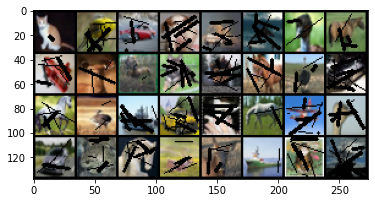

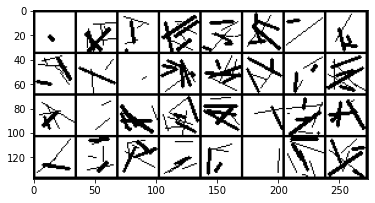

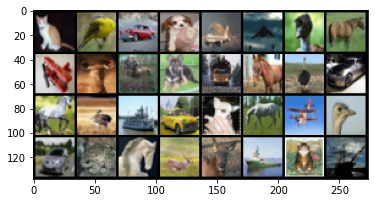

In [13]:
show_grid(torchvision.utils.make_grid(x_in))
show_grid(torchvision.utils.make_grid(x_mask))
show_grid(torchvision.utils.make_grid(y_out))

# Partial Convolution

In [23]:
class PartialConv(nn.Module):
    def __init__(self, in_filters, out_filters, kernel_size, strides=1, padding=0, dilation=1, groups=1, bias=True):
        super(PartialConv, self).__init__()

        padding = (kernel_size[0] // 2, kernel_size[1] // 2)
        self.input_conv = nn.Conv2d(in_filters, out_filters, kernel_size, strides, padding, bias=bias)
        self.mask_conv = nn.Conv2d(in_filters, out_filters, kernel_size, strides, padding, bias=False)
        
        self.window_size = kernel_size[0] * kernel_size[1]

        nn.init.constant_(self.mask_conv.weight, 1.0)

        for param in self.mask_conv.parameters():
            param.requires_grad = False

    def forward(self, input, mask):
        output = self.input_conv(input * mask)
        if self.input_conv.bias is not None:
            output_bias = self.input_conv.bias.view(1, -1, 1, 1).expand_as(output)
        else:
            output_bias = torch.zeros_like(output)

        with torch.no_grad():
            output_mask = self.mask_conv(mask)

        mask_ratio = self.window_size / (output_mask + 1e-8)

        output_mask = torch.clamp(output_mask, 0, 1)
  
        mask_ratio = mask_ratio * output_mask

        output = output * mask_ratio

        output = output + output_bias

        return output, output_mask

# Partial Convolution Based AutoEncoder-Decoder Model

In [24]:
class EncoderLayer(nn.Module):
    def __init__(self, in_filters, out_filters):
        super(EncoderLayer, self).__init__()
        self.p_conv_1 = PartialConv(in_filters, out_filters, (3, 3), strides=1)
        self.act_1 = nn.ReLU()
        self.p_conv_2 = PartialConv(out_filters, out_filters, (3, 3), strides=2)
        self.act_2 = nn.ReLU()

    def forward(self, inputs, masks):
        conv_out_1, mask_out_1 = self.p_conv_1(inputs, masks)
        conv_out_1 = self.act_1(conv_out_1)

        conv_out_2, mask_out_2 = self.p_conv_2(conv_out_1, mask_out_1)
        conv_out_2 = self.act_2(conv_out_2)

        return conv_out_1, mask_out_1, conv_out_2, mask_out_2

In [25]:
class DecoderLayer(nn.Module):
    def __init__(self, in_filters_1, in_filters_2):
        super(DecoderLayer, self).__init__()

        self.up_image = nn.Upsample(scale_factor=(2, 2))
        self.up_mask = nn.Upsample(scale_factor=(2, 2))
        
        self.p_conv_1 = PartialConv(in_filters_1 * 2, in_filters_1, (3, 3))
        self.act_1 = nn.LeakyReLU(negative_slope=0.2)
        self.p_conv_2 = PartialConv(in_filters_1, in_filters_2, (3, 3))
        self.act_2 = nn.LeakyReLU(negative_slope=0.2)

    def forward(self, in_image, in_mask, share_image, share_mask):
        up_out = self.up_image(in_image)
        mask_out = self.up_mask(in_mask)

        concat_image = torch.cat([share_image, up_out], axis=1)
        concat_mask = torch.cat([share_mask, mask_out], axis=1)

        conv_out_1, mask_out_1 = self.p_conv_1(concat_image, concat_mask)
        conv_out_1 = self.act_1(conv_out_1)
    
        conv_out_2, mask_out_2 = self.p_conv_2(conv_out_1, mask_out_1)
        conv_out_2 = self.act_2(conv_out_2)

        return conv_out_1, mask_out_1, conv_out_2, mask_out_2

In [26]:
class InpaintingModel(nn.Module):
    def __init__(self, input_dims=(32, 32), num_channels=3):
        super(InpaintingModel, self).__init__()

        self.encoder_1 = EncoderLayer(num_channels, 32)
        self.encoder_2 = EncoderLayer(32, 64)
        self.encoder_3 = EncoderLayer(64, 128)
        self.encoder_4 = EncoderLayer(128, 256)

        self.decoder_1 = DecoderLayer(256, 128)
        self.decoder_2 = DecoderLayer(128, 64)
        self.decoder_3 = DecoderLayer(64, 32)
        self.decoder_4 = DecoderLayer(32, 3)

        self.output_layer = nn.Sequential(
            nn.Conv2d(3, 3, (3, 3), padding=1),
            nn.Sigmoid()
        )

    def forward(self, inputs, masks):
        conv_out_1, mask_out_1, conv_out_2, mask_out_2 = self.encoder_1(inputs, masks)
        conv_out_3, mask_out_3, conv_out_4, mask_out_4 = self.encoder_2(conv_out_2, mask_out_2)
        conv_out_5, mask_out_5, conv_out_6, mask_out_6 = self.encoder_3(conv_out_4, mask_out_4)
        conv_out_7, mask_out_7, conv_out_8, mask_out_8 = self.encoder_4(conv_out_6, mask_out_6)

        conv_out_9, mask_out_9, conv_out_10, mask_out_10 = self.decoder_1(conv_out_8, mask_out_8, conv_out_7, mask_out_7)
        conv_out_11, mask_out_11, conv_out_12, mask_out_12 = self.decoder_2(conv_out_6, mask_out_6, conv_out_5, mask_out_5)
        conv_out_13, mask_out_13, conv_out_14, mask_out_14 = self.decoder_3(conv_out_4, mask_out_4, conv_out_3, mask_out_3)
        conv_out_15, mask_out_15, conv_out_16, mask_out_16 = self.decoder_4(conv_out_2, mask_out_2, conv_out_1, mask_out_1)

        outputs = self.output_layer(conv_out_16)
        return outputs


In [27]:
model = InpaintingModel()
model.cuda()

InpaintingModel(
  (encoder_1): EncoderLayer(
    (p_conv_1): PartialConv(
      (input_conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (mask_conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (act_1): ReLU()
    (p_conv_2): PartialConv(
      (input_conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (mask_conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    )
    (act_2): ReLU()
  )
  (encoder_2): EncoderLayer(
    (p_conv_1): PartialConv(
      (input_conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (mask_conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (act_1): ReLU()
    (p_conv_2): PartialConv(
      (input_conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (mask_conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=Fals

# Training

In [28]:
def dice_coef(y_true, y_pred):
    y_true_f = y_true.view(-1)
    y_pred_f = y_pred.view(-1)
    intersection = torch.sum(y_true_f * y_pred_f)
    return (2. * intersection) / (torch.sum(y_true_f + y_pred_f))

Initialize the optimizer, loss and metrics

In [29]:
optimizer = optim.Adam(model.parameters())
loss = nn.MSELoss()
metrics = dice_coef

In [30]:
def log_wandb(epoch, train_loss, train_dice, val_loss, val_dice, model, data_iter):
    wandb.log({'train_loss': train_loss, 'train_dice': train_dice, 'val_loss': val_loss, 'val_dice': val_dice}, step=epoch)

    sample_inputs, sample_masks, sample_truth = data_iter.next()
    sample_inputs, sample_masks = sample_inputs.cuda(), sample_masks.cuda()
    
    with torch.no_grad():
        sample_preds = model(sample_inputs, sample_masks)

    def convert_to_grid(images):
        return torchvision.utils.make_grid(images.cpu())
    
    wandb.log({"images": wandb.Image(convert_to_grid(sample_inputs))}, step=epoch)
    wandb.log({"masked": wandb.Image(convert_to_grid(sample_masks))}, step=epoch)
    wandb.log({"labels": wandb.Image(convert_to_grid(sample_truth))}, step=epoch)
    wandb.log({"predictions": wandb.Image(convert_to_grid(sample_preds.detach()))}, step=epoch)

In [31]:
pbar = tqdm()

for epoch in range(epochs):

    # Train Step
    pbar.reset(total=len(train_dataloader))
    train_losses = []
    train_scores = []
    model.train()
    for i, (X_input, X_mask, y_output) in enumerate(train_dataloader):

        X_input, X_mask, y_output = X_input.cuda(), X_mask.cuda(), y_output.cuda()
        
        model.zero_grad()
        pred_output = model(X_input, X_mask)
        
        batch_loss = loss(y_output, pred_output)
        train_losses.append(batch_loss)
        batch_loss.backward()
        
        optimizer.step()

        score = metrics(y_output, pred_output)
        train_scores.append(score)

        pbar.update()

    # Validation Step
    pbar.reset(total=len(test_dataloader))
    val_scores = []
    val_losses = []
    model.eval()
    with torch.no_grad():
        for i, (X_input, X_mask, y_output) in enumerate(test_dataloader):

            X_input, X_mask, y_output = X_input.cuda(), X_mask.cuda(), y_output.cuda()

            pred_output = model(X_input, X_mask)
            
            batch_loss = loss(y_output, pred_output)
            val_losses.append(batch_loss)
            
            score = metrics(y_output, pred_output)
            val_scores.append(score)

            pbar.update()

    # Logging
    train_loss = sum(train_losses) / len(train_losses)
    train_dice = sum(train_scores) / len(train_scores)
    val_loss = sum(val_losses) / len(val_losses)
    val_dice = sum(val_scores) / len(val_scores)

    log_wandb(epoch + 1, train_loss, train_dice, val_loss, val_dice, model, iter(test_dataloader))

    print(f'Epoch: {epoch + 1}/{epochs}')
    print(f'Train Loss: {train_loss} - Train Dice Coeff: {train_dice}')
    print(f'Valid Loss: {val_loss} - Valid Dice Coeff: {val_dice}')

Epoch: 1/20
Train Loss: 0.01663384586572647 - Train Dice Coeff: 0.5715059041976929
Valid Loss: 0.01121029444038868 - Valid Dice Coeff: 0.5818508863449097
Epoch: 2/20
Train Loss: 0.010462791658937931 - Train Dice Coeff: 0.5836252570152283
Valid Loss: 0.009273539297282696 - Valid Dice Coeff: 0.5878393054008484
Epoch: 3/20
Train Loss: 0.006632664706557989 - Train Dice Coeff: 0.590836226940155
Valid Loss: 0.005519982893019915 - Valid Dice Coeff: 0.5969070196151733
Epoch: 4/20
Train Loss: 0.0050220065750181675 - Train Dice Coeff: 0.5945577621459961
Valid Loss: 0.004548212978988886 - Valid Dice Coeff: 0.6003385782241821
Epoch: 5/20
Train Loss: 0.004261574242264032 - Train Dice Coeff: 0.5962806940078735
Valid Loss: 0.004056648816913366 - Valid Dice Coeff: 0.5981366038322449
Epoch: 6/20
Train Loss: 0.0038900338113307953 - Train Dice Coeff: 0.5971484184265137
Valid Loss: 0.0037576614413410425 - Valid Dice Coeff: 0.6004132628440857
Epoch: 7/20
Train Loss: 0.0035705161280930042 - Train Dice Coeff

# Output Samples

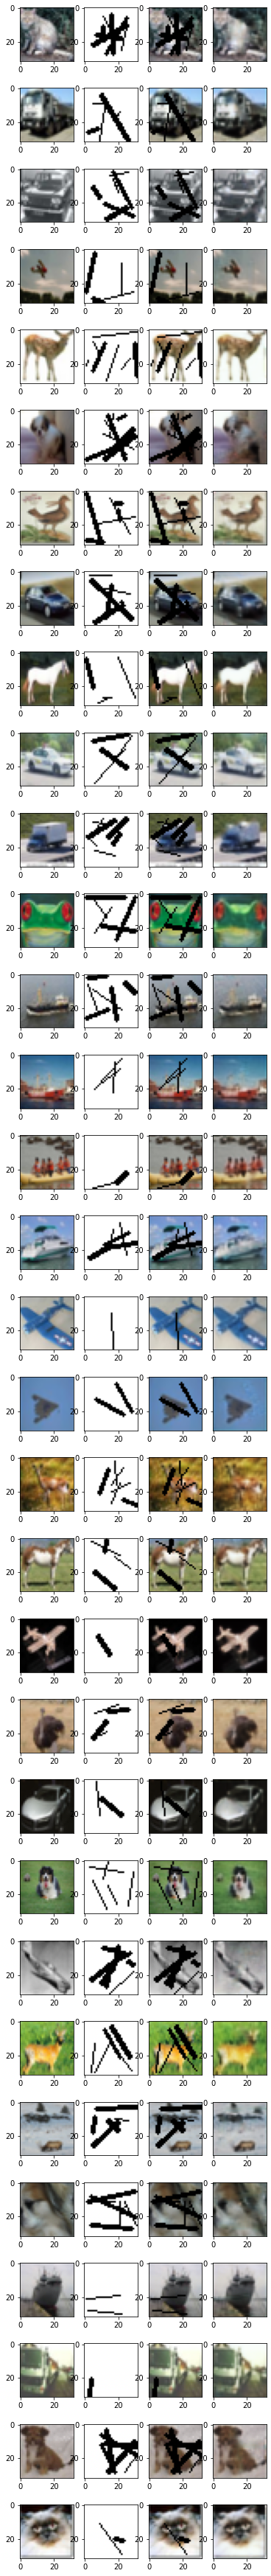

In [32]:
sample_inputs, sample_masks, sample_truths = train_dataiter.next()
sample_inputs, sample_masks = sample_inputs.cuda(), sample_masks.cuda()

model.eval()
with torch.no_grad():
    sample_preds = model(sample_inputs, sample_masks)

fig, axs = plt.subplots(nrows=32, ncols=4, figsize=(6, 2 * 32))

sample_inputs, sample_masks = sample_inputs.cpu(), sample_masks.cpu()
for i in range(32):
    axs[i][0].imshow(np.transpose(sample_truths[i], (1, 2, 0)))
    axs[i][1].imshow(np.transpose(sample_masks[i], (1, 2, 0)))
    axs[i][2].imshow(np.transpose(sample_inputs[i], (1, 2, 0)))
    axs[i][3].imshow(np.transpose(sample_preds[i].cpu().numpy(), (1, 2, 0)))